In [1]:
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu
import warnings

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 16
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['axes.linewidth'] = 2
rcParams['grid.linewidth'] = 2
rcParams['grid.color'] = 'gainsboro'
rcParams['font.weight'] = 'normal'
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['legend.edgecolor'] = 'none'
warnings.filterwarnings('ignore')

In [3]:
reg_dic = {'0':'Liver mets',
'1':'Omentum',
'2':'RUQ',
'3':'LUQ',
'4':'Epigastrium',
'5':'Mesentery',
'6':'Left paracolic gutter',
'7':'Right paracolic gutter',
'8':'Nothing',
'9':'POD',
'10':'Nothing',
'11':'Pleural',
'12':'Abd. wall',
'13':'LN abdomen infrarenal',
'14':'LN abdomen suprarenal',
'15':'LN supradiaphragmatic',
'16':'LN chest',
'17':'LN inguinal',
'18':'Lung nodule'}

In [4]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0}$\times$10$^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

In [5]:
df_in = pd.read_csv('../prediction/inputs/training_df.csv')

In [6]:
df_aux1 = pd.read_csv('../data/neov-segmentation-volumes.csv')
df_aux2 = pd.read_csv('../data/neov-extra-annotations.csv')
df_aux3 = pd.read_csv('../data/neov-recist.csv')[['ID','recist_summed_diameter_scan2','response_volume']]

In [7]:
new_cols = [x for x in df_aux1.columns.values if x not in df_in.columns.values]
df = pd.merge(left=df_in, right=df_aux1[new_cols], left_on='id', right_on='patientID', how='inner')
df = pd.merge(left=df, right=df_aux2, left_on='id', right_on='ID', how='inner')
df = pd.merge(left=df, right=df_aux3, left_on='id', right_on='ID', how='inner')

In [8]:
df['rel_vol_change'] = df['total_vol_2']/df['total_vol_1']

In [9]:
df['rel_recist_change'] = ((df['recist_summed_diameter_scan2']-df['recist_summed_diameter_scan1'])/df['recist_summed_diameter_scan1']).copy()

## Figure 1d

In [10]:
ln_vol = np.concatenate( (df['15-vol_1'], df['16-vol_1'], df['17-vol_1']) )
ln_vol = np.log(ln_vol[np.nonzero(ln_vol)])

ln_abd_vol = np.concatenate( (df['13-vol_1'], df['14-vol_1']) )
ln_abd_vol = np.log(ln_abd_vol[np.nonzero(ln_abd_vol)])

quad_vol = np.concatenate( (df['2-vol_1'], df['3-vol_1']) )
quad_vol = np.log(quad_vol[np.nonzero(quad_vol)])

pme_vol = np.concatenate( (df['4-vol_1'],df['5-vol_1'],df['6-vol_1'],df['7-vol_1']) )
pme_vol = np.log(pme_vol[np.nonzero(pme_vol)])

om_vol = df['1-vol_1'].values
om_vol = np.log(om_vol[np.nonzero(om_vol)])

pod_vol = df['9-vol_1'].values
pod_vol = np.log(pod_vol[np.nonzero(pod_vol)])

mets_vol = df['0-vol_1'].values

vol_categs = np.array([ln_vol, pme_vol, ln_abd_vol, quad_vol, om_vol, pod_vol])

categ_names = np.array(['Extraabdominal LNs', 'Abdominal LNs', 'Upper abdominal quad.', 'Paracolic, mesenteric,\nepigastric', 'Omentum', 'Ovaries and pelvis'])

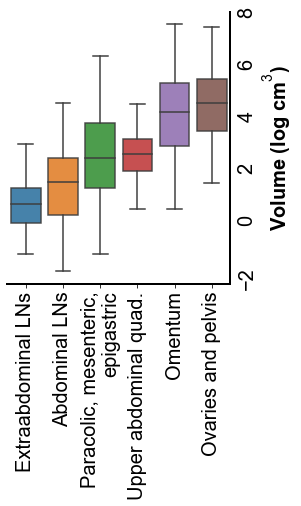

In [11]:
order = np.argsort([np.mean(x) for x in vol_categs])

f, ax = plt.subplots(figsize=(4,5))
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
sns.boxplot(data=vol_categs[order], fliersize=0, boxprops=dict(alpha=.9))
plt.yticks(size=20, rotation=90)
plt.xticks(range(len(vol_categs)), categ_names[order], rotation=90, size=20, multialignment='right')
plt.ylabel('Volume (log cm$^3$)')

sns.despine(left=True, right=False)

plt.show()

# Print source data
outfile = open('data-export/figure_1d.txt','w')
for i in range(len(order)):
    newline = '"{}",{}\n'.format(categ_names[order][i], ','.join([str(j) for j in vol_categs[order][i]]))
    outfile.write(newline)
outfile.close()

## Figure 1e

In [12]:
ln_num = df[(df['15-vol_1']>0) | (df['16-vol_1']>0) | (df['17-vol_1']>0)].shape[0]
ln_abd_num = df[(df['13-vol_1']>0) | (df['14-vol_1']>0)].shape[0]
quad_num = df[(df['2-vol_1']>0) | (df['3-vol_1']>0)].shape[0]
pme_num = df[(df['4-vol_1']>0) | (df['5-vol_1']>0) | (df['6-vol_1']>0) | (df['7-vol_1']>0)].shape[0]
om_num = df['1-vol_1'].shape[0]
pod_num = df['9-vol_1'].shape[0]
mets_num = df['0-vol_1'].shape[0]

num_categs = np.array([ln_num, pme_num, ln_abd_num, quad_num, om_num, pod_num])

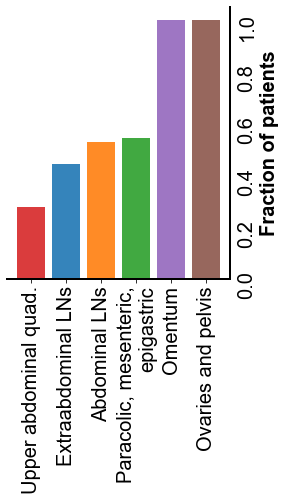

In [13]:
f, ax = plt.subplots(figsize=(4,5))
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
order = np.argsort(num_categs)
colors = ['C3','C0','C1','C2','C4','C5']
plt.bar(x=range(len(num_categs)), height=num_categs[order]/df.shape[0], color=colors, alpha=0.9)
plt.xticks(range(len(num_categs)), categ_names[order], rotation=90, size=20, multialignment='right')
plt.yticks(size=20,rotation=90)
plt.ylabel('Fraction of patients')

sns.despine(left=True, right=False)

plt.show()

# Print source data
outfile = open('data-export/figure_1e.txt','w')
for i in range(len(num_categs)): 
    newline = '"{}",{}\n'.format(categ_names[order][i], num_categs[order][i]/df.shape[0])
    outfile.write(newline)
outfile.close()

## Figure 1f

In [14]:
om_vol_change = df['1-vol_2'].values/df['1-vol_1'].values
df['om_vol_change'] = om_vol_change
om_vol_change = om_vol_change[~np.isnan(om_vol_change)]

pod_vol_change = df['9-vol_2'].values/df['9-vol_1'].values
df['pod_vol_change'] = pod_vol_change
pod_vol_change = pod_vol_change[~np.isnan(pod_vol_change)]

vol_changes = [om_vol_change, pod_vol_change]

In [15]:
_, p = mannwhitneyu(om_vol_change, pod_vol_change, alternative='two-sided')
print(p)

0.0001215802366587209


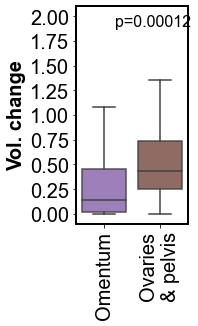

In [16]:
plt.figure(figsize=(2,4))
sns.boxplot(data=vol_changes, fliersize=0, palette={0:'C4', 1:'C5'}, boxprops=dict(alpha=.9))
#sns.stripplot(data=vol_changes, color='0.25')
plt.ylim([-0.1,2.1])
plt.yticks(size=20)
plt.xticks([0,1],['Omentum','Ovaries\n& pelvis'],rotation=90,size=20)
plt.ylabel('Vol. change',fontweight='bold')

plt.text(0.2, 1.9, 'p={}'.format(latex_float(p)), size=16)

#if p<0.0001:
#    plt.text(0.2, 1.9, '$p$<0.0001')
#else:
#    print(p)
#    plt.text(0.2, 1.9, '$p$={:.4f}'.format(p), size=16)
plt.show()



# Print source data
outfile = open('data-export/figure_1f.txt','w')
outfile.write('"Omentum", {}\n'.format(','.join(str(j) for j in om_vol_change)))
outfile.write('"Ovaries & pelvis", {}\n'.format(','.join(str(j) for j in pod_vol_change)))
outfile.close()

## Figure 1g

In [17]:
from scipy.stats import pointbiserialr

PointbiserialrResult(correlation=0.7884002096711, pvalue=2.0267090405640948e-16)


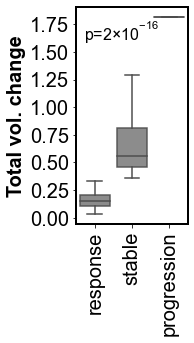

In [18]:
df_pbs = df.copy()
df_pbs['recist_num'] = df_pbs['response_volume']
df_pbs['recist_num'].replace('response',1,inplace=True)
df_pbs['recist_num'].replace('stable',2,inplace=True)
df_pbs['recist_num'].replace('progression',3,inplace=True)
pbs = pointbiserialr(df_pbs['recist_num'], df_pbs['rel_vol_change'])
print(pbs)

plt.figure(figsize=(2,4))
sns.boxplot(data=df, x='response_volume', y='rel_vol_change', fliersize=0, boxprops=dict(alpha=.9), color='grey')
plt.yticks(size=20)
plt.xticks(size=20)
plt.xticks(rotation=90)
plt.ylabel('Total vol. change')
plt.xlabel('')

plt.text(-0.3, 1.6, 'p={}'.format(latex_float(pbs.pvalue)), size=16)

#if pbs.pvalue<0.0001:
    #plt.text(-0.3, 1.6, '$p$<0.0001', size=16)
#else:
    #plt.text(-0.3, 1.6, '$p$={:.2f}'.format(pbs.pvalue), size=16)

plt.show()

# Print source data
df[['response_volume', 'rel_vol_change']].to_csv('data-export/figure_1g_totalvol.txt')

PointbiserialrResult(correlation=0.8017876078601603, pvalue=6.028523892813219e-16)


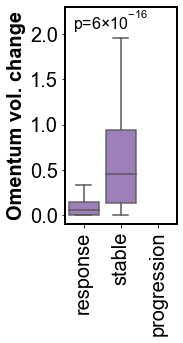

In [19]:
df_om = df[~np.isnan(df['om_vol_change'])]

df_pbs_om = df_om.copy()
df_pbs_om['recist_num'] = df_pbs_om['response_volume']
df_pbs_om['recist_num'].replace('response',1,inplace=True)
df_pbs_om['recist_num'].replace('stable',2,inplace=True)
df_pbs_om['recist_num'].replace('progression',3,inplace=True)
pbs = pointbiserialr(df_pbs_om['recist_num'], df_pbs_om['rel_vol_change'])
print(pbs)

plt.figure(figsize=(2,4))
sns.boxplot(data=df_om, x='response_volume', y='om_vol_change', fliersize=0, boxprops=dict(alpha=.9), color='C4')
plt.ylim([-0.1,2.3])
plt.yticks(size=20)
plt.xticks(size=20)
plt.xticks(rotation=90)
plt.ylabel('Omentum vol. change')
plt.xlabel('')

plt.text(-0.3, 2.05, 'p={}'.format(latex_float(pbs.pvalue)), size=16)

#if pbs.pvalue<0.0001:
#    plt.text(-0.3, 2.1, '$p$<0.0001', size=16)
#else:
#    plt.text(-0.3, 2.1, '$p$={:.2f}'.format(pbs.pvalue), size=16)

plt.show()


# Print source data
df[['response_volume', 'om_vol_change']].to_csv('data-export/figure_1g_omentum.txt')

PointbiserialrResult(correlation=0.7949470142705194, pvalue=9.596260306587469e-16)


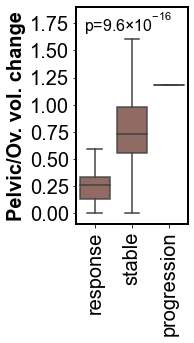

In [20]:
df_pod = df[~np.isnan(df['pod_vol_change'])]

df_pbs_pod = df_pod.copy()
df_pbs_pod['recist_num'] = df_pbs_pod['response_volume']
df_pbs_pod['recist_num'].replace('response',1,inplace=True)
df_pbs_pod['recist_num'].replace('stable',2,inplace=True)
df_pbs_pod['recist_num'].replace('progression',3,inplace=True)
pbs = pointbiserialr(df_pbs_pod['recist_num'], df_pbs_pod['rel_vol_change'])
print(pbs)

plt.figure(figsize=(2,4))
sns.boxplot(data=df_om, x='response_volume', y='pod_vol_change', fliersize=0, boxprops=dict(alpha=.9), color='C5')
plt.ylim([-0.1,1.9])
plt.yticks(size=20)
plt.xticks(size=20)
plt.xticks(rotation=90)
plt.ylabel('Pelvic/Ov. vol. change')
plt.xlabel('')

plt.text(-0.3, 1.67, 'p={}'.format(latex_float(pbs.pvalue)), size=16)


#if pbs.pvalue<0.0001:
#    plt.text(-0.3, 1.7, '$p$<0.0001', size=16)
#else:
#    plt.text(-0.3, 1.7, '$p$={:.2f}'.format(pbs.pvalue), size=16)


plt.show()

# Print source data
df[['response_volume', 'pod_vol_change']].to_csv('data-export/figure_1g_pod.txt')

## Figure 1h

In [21]:
df_brca = pd.read_csv('../data/neov-brca-survival.csv')

In [22]:
diff_cols = [x for x in df_brca.columns.values if x not in df.columns.values]
full_df = pd.merge(df, df_brca[diff_cols], how='inner', left_on='id', right_on='ID')

In [23]:
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind

In [24]:
full_df['BRCA_grouped'].replace('HRD','BRCA_mut',inplace=True)
full_df['BRCA_grouped'].replace('VUS','BRCA_mut',inplace=True)

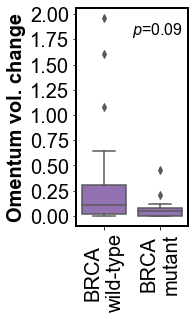

In [25]:
safe = (~full_df['BRCA_grouped'].isnull().values) & (~full_df['om_rel_change'].isnull().values)
safe_df = full_df[safe].copy()
brca_grouped_ind = pd.factorize(safe_df.loc[:,'BRCA_grouped'])[0]

_, p = mannwhitneyu(safe_df.loc[brca_grouped_ind==0,'om_rel_change'].values, safe_df.loc[brca_grouped_ind==1,'om_rel_change'].values, alternative='two-sided')

plt.figure(figsize=(2,4))
sns.boxplot(data=safe_df, x='BRCA_grouped', y='om_rel_change', color='C4')
plt.xlabel('')
plt.yticks(size=20)
plt.xticks(size=20)
plt.xticks([0,1],['BRCA\nwild-type','BRCA\nmutant'],rotation=90)
plt.ylabel('Omentum vol. change')
plt.text(0.5, 1.8, '$p$={:.2f}'.format(p), size=16)
plt.show()

# Print source data
safe_df[['BRCA_grouped', 'om_rel_change']].to_csv('data-export/figure_1h_omentum.txt')

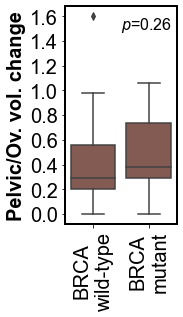

In [26]:
safe = (~full_df['BRCA_grouped'].isnull().values) & (~full_df['pod_rel_change'].isnull().values)
safe_df = full_df[safe].copy()
brca_grouped_ind = pd.factorize(safe_df.loc[:,'BRCA_grouped'])[0]

_, p = mannwhitneyu(safe_df.loc[brca_grouped_ind==0,'pod_rel_change'].values, safe_df.loc[brca_grouped_ind==1,'pod_rel_change'].values, alternative='two-sided')

plt.figure(figsize=(2,4))
sns.boxplot(data=safe_df, x='BRCA_grouped', y='pod_rel_change', color='C5')
plt.xlabel('')
plt.yticks(size=20)
plt.xticks([0,1],['BRCA\nwild-type','BRCA\nmutant'],rotation=90,size=20)
plt.ylabel('Pelvic/Ov. vol. change')
plt.text(0.5, 1.5, '$p$={:.2f}'.format(p),size=16)
plt.show()

# Print source data
safe_df[['BRCA_grouped', 'pod_rel_change']].to_csv('data-export/figure_1h_pod.txt')

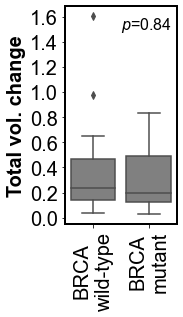

In [27]:
safe = (~full_df['BRCA_grouped'].isnull().values) & (~full_df['rel_vol_change'].isnull().values)
safe_df = full_df[safe].copy()
brca_grouped_ind = pd.factorize(safe_df.loc[:,'BRCA_grouped'])[0]

_, p = mannwhitneyu(safe_df.loc[brca_grouped_ind==0,'rel_vol_change'].values, safe_df.loc[brca_grouped_ind==1,'rel_vol_change'].values, alternative='two-sided')

plt.figure(figsize=(2,4))
sns.boxplot(data=safe_df, x='BRCA_grouped', y='rel_vol_change', color='grey')
plt.xlabel('')
plt.yticks(size=20)
plt.xticks([0,1],['BRCA\nwild-type','BRCA\nmutant'],rotation=90,size=20)
plt.ylabel('Total vol. change',fontweight='bold')
plt.text(0.5, 1.5, '$p$={:.2f}'.format(p),size=16)
plt.show()


# Print source data
safe_df[['BRCA_grouped', 'rel_vol_change']].to_csv('data-export/figure_1h_totalvol.txt')